# Kailua Bay Rouse Number

Loading librairies...

In [1]:
import csv
import numpy as np
from scipy import interpolate
import scipy.ndimage as ndimage

import cmocean as cmo
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import netCDF4
import pandas as pd
import datetime as dt

from mpl_toolkits.basemap import Basemap

from scipy.spatial import cKDTree
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pykrige.uk import UniversalKriging
from pykrige.ok import OrdinaryKriging

## Loading dataset 

In [2]:
# Grid related dataset:
gridxi = np.load("data/gridxi.dat")
gridyi = np.load("data/gridyi.dat")
gridzi = np.load("data/gridzi.dat")
gridUw = np.load("data/gridUw.dat")
gridT = np.load("data/gridT.dat")
gridH = np.load("data/gridH.dat")

# Sample related dataset
gzLon = np.load("data/gzLon.dat")
gzLat = np.load("data/gzLat.dat")
gzPts = np.load("data/gridgz.dat")

#allLon = np.load("data/allLon.dat")
#allLat = np.load("data/allLat.dat")
#allGZ = np.load("data/allGZ.dat")
#ngridX = np.load("data/ngridX.dat")
#ngridY = np.load("data/ngridY.dat")

## Kailua Bay grid

We used the following dataset from the **PacIOOS** (_Pacific Istands Ocean Observing System_): 
- [link to the dataset](http://oos.soest.hawaii.edu/thredds/dodsC/hioos/model/wav/swan/oahu/SWAN_Oahu_Regional_Wave_Model_best.ncd.html)

From the Oahu grid we will now focus on the Kailua Bay

In [48]:
minlat = 21.387
maxlat = 21.429
minlon = 360.-157.756
maxlon = 360.-157.72

We will first define our grid resolution and interpolate the netcdf dataset to the appropriate grid resolution.

In [49]:
grid_res = 0.0008
ngridX = np.arange(minlon,maxlon+grid_res,grid_res)
ngridY = np.arange(minlat,maxlat+grid_res,grid_res)
kailuaxi, kailuayi = np.meshgrid(ngridX, ngridY)

### Interpolation from Oahu grid

First we build the interpolation functions

In [50]:
# Wave height
RGI_function = RegularGridInterpolator((gridyi[:,0].flatten(),gridxi[0,:].flatten()), gridH)
# Wave period
RGI_function1 = RegularGridInterpolator((gridyi[:,0].flatten(),gridxi[0,:].flatten()), gridT)
# Bathymetry
RGI_function2 = RegularGridInterpolator((gridyi[:,0].flatten(),gridxi[0,:].flatten()), gridzi)
# Bottom velocity
RGI_function3 = RegularGridInterpolator((gridyi[:,0].flatten(),gridxi[0,:].flatten()), gridUw)

Then we perform the interpolation

In [51]:
kailuaZ = RGI_function2((kailuayi.flatten(), kailuaxi.flatten()))
kailuaH = RGI_function((kailuayi.flatten(), kailuaxi.flatten()))
kailuaT = RGI_function1((kailuayi.flatten(), kailuaxi.flatten()))
kailuaUw = RGI_function3((kailuayi.flatten(), kailuaxi.flatten()))

We reshape the vectors in 2D arrays:

In [52]:
kailuaZ = kailuaZ.reshape((kailuayi.shape))
kailuaH = kailuaH.reshape((kailuayi.shape))
kailuaT = kailuaT.reshape((kailuayi.shape))
kailuaUw = kailuaUw.reshape((kailuayi.shape))

r,c = np.where(kailuaZ>0)
kailuaH[r,c] = 0.
kailuaT[r,c] = 0.
kailuaUw[r,c] = 0.

## Visualise dataset

### Bathymetry

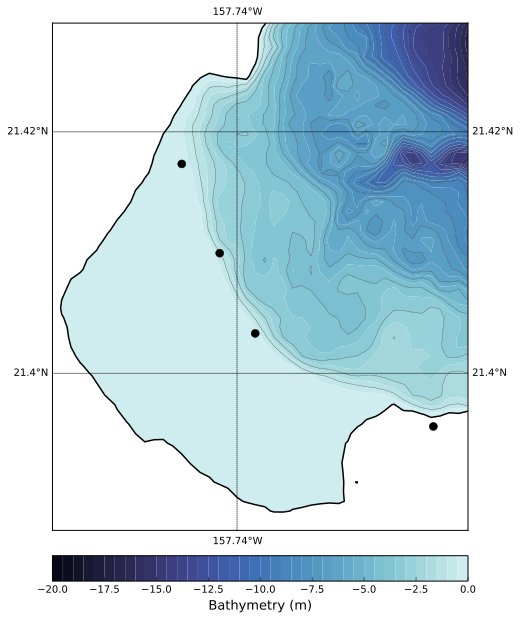

In [60]:
fig = plt.figure()
rcParams['figure.figsize'] = (14,10)
oahu_map = Basemap(projection='mill', llcrnrlat=minlat,
                urcrnrlat=maxlat, llcrnrlon=minlon, 
                urcrnrlon=maxlon, resolution = 'h')

xHawaii, yHawaii = oahu_map(kailuaxi, kailuayi)

oahu_map.drawmapboundary()

# Parallels & meridians 
parallels = np.arange(21, 22, 0.02)
meridians = np.arange(-160, -157, 0.02)
oahu_map.drawparallels(parallels,labels=[True,True,True,True])
oahu_map.drawmeridians(meridians,labels=[True,True,True,True])

# Visualise bathymetry
cs = oahu_map.contourf(xHawaii,yHawaii,kailuaZ, levels=np.arange(-20,0.5,0.5), 
                       cmap=cmo.cm.ice,  vmin=-20, vmax=1 )

contour = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(0, 100, 100), 
                           colors = 'k', linestyles = 'solid',linewidths=1.5)

contour2 = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(-25, 0, 1), 
                           colors = 'k', linestyles = 'solid',linewidths=0.25)

#contour3 = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(-50, 0, 5), 
#                           colors = 'k', linestyles = 'solid',linewidths=0.25)

#contour4 = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(-5, 0, 0.5), 
#                           colors = 'k', linestyles = 'dashed',linewidths=0.25)

# Add grain-size location to the map
xgz,ygz = oahu_map(gzLon, gzLat)
oahu_map.plot(xgz, ygz, 'ko', markersize=8)

cbar = oahu_map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Bathymetry (m)',size=13)

plt.show()
fig.savefig('figs/zone1.pdf')

### Wave height

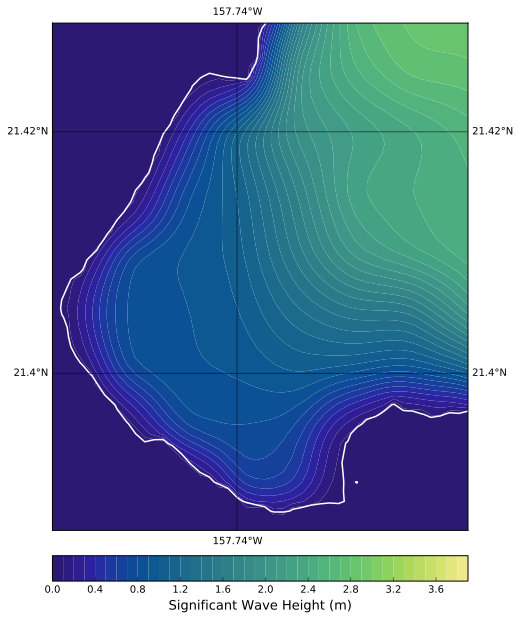

In [61]:
fig = plt.figure()
rcParams['figure.figsize'] = (14,10)

oahu_map.drawmapboundary()

# Parallels & meridians 
parallels = np.arange(21, 22, 0.02)
meridians = np.arange(-160, -157, 0.02)
oahu_map.drawparallels(parallels,labels=[True,True,True,True])
oahu_map.drawmeridians(meridians,labels=[True,True,True,True])


# Visualise wave height
cs = oahu_map.contourf(xHawaii, yHawaii, kailuaH, levels=np.arange(0,4,0.1), 
                       cmap=cmo.cm.haline,  vmin=0, vmax=4 )

# Add shoreline contour
contour = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(0, 100, 100), 
                           colors = 'w', linestyles = 'solid',linewidths=1.5)

cbar = oahu_map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Significant Wave Height (m)',size=13)

plt.show()
fig.savefig('figs/zone1H.pdf')

### Wave period

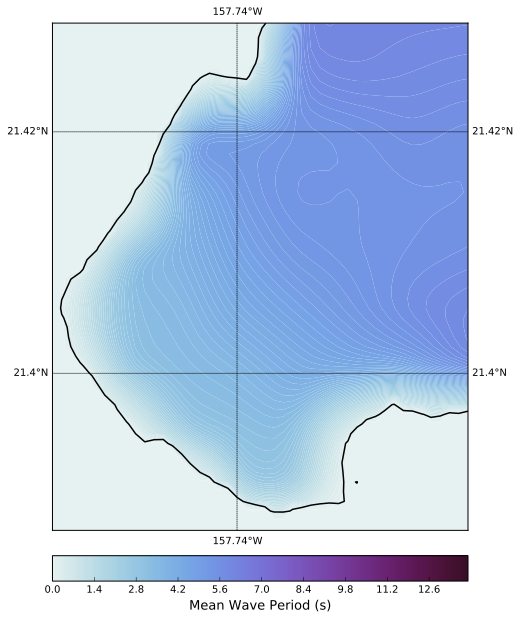

In [62]:
fig = plt.figure()
rcParams['figure.figsize'] = (14,10)

oahu_map.drawmapboundary()

# Parallels & meridians 
parallels = np.arange(21, 22, 0.02)
meridians = np.arange(-160, -157, 0.02)
oahu_map.drawparallels(parallels,labels=[True,True,True,True])
oahu_map.drawmeridians(meridians,labels=[True,True,True,True])

# Visualise wave period
cs = oahu_map.contourf(xHawaii, yHawaii, kailuaT, levels=np.arange(0,14,0.1), 
                       cmap=cmo.cm.dense,  vmin=0, vmax=14 )

# Add shoreline contour
contour = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(0, 100, 100), 
                           colors = 'k', linestyles = 'solid',linewidths=1.5)

cbar = oahu_map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Mean Wave Period (s)',size=13)

plt.show()
#fig.savefig('figs/zone1T.pdf')

## Orbital bottom velocity

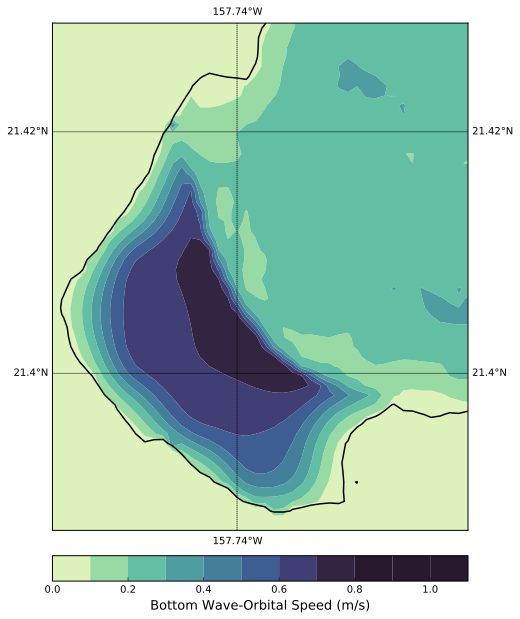

In [79]:
fig = plt.figure()
rcParams['figure.figsize'] = (14,10)

oahu_map.drawmapboundary()

# Parallels & meridians 
parallels = np.arange(21, 22, 0.02)
meridians = np.arange(-160, -157, 0.02)
oahu_map.drawparallels(parallels,labels=[True,True,True,True])
oahu_map.drawmeridians(meridians,labels=[True,True,True,True])

# Visualise wave height
cs = oahu_map.contourf(xHawaii, yHawaii, kailuaUw, levels=np.arange(0,1.2,0.1), 
                       cmap=cmo.cm.deep,  vmin=0, vmax=0.8 )

# Add shoreline contour
contour = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(0, 100, 100), 
                           colors = 'k', linestyles = 'solid',linewidths=1.5)

cbar = oahu_map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Bottom Wave-Orbital Speed (m/s)',size=13)

plt.show()
fig.savefig('figs/zone1Ub.pdf')

## Kriging of grain-size sample

We perform Kriging on the dataset extracted from **USGS** using the following link:

- [dataset link](https://pubs.usgs.gov/of/2003/0441/data.html)

#### Description

Vibracores were collected from offshore locations: Kailua only in 1997, Kailua, North Coast, Leeward coast and South Coast in 2000. In April, 1998 beach samples were collected from beaches around the island of Oahu at approximately three locations along survey lines.

First we pick the sample for Kailua Bay:

In [64]:
idIn = np.where(np.logical_and(gzLon>ngridX.min(),gzLon<ngridX.max()))[0]
tmpLon = gzLon[idIn]
tmpLat = gzLat[idIn]
tmpGZ = gzPts[idIn]
idIn = np.where(np.logical_and(tmpLat>ngridY.min(),tmpLat<ngridY.max()))[0]
kLon = tmpLon[idIn]
kLat = tmpLat[idIn]
kGZ = tmpGZ[idIn]

In [76]:
print kGZ.min(),kGZ.max(),len(kGZ)
meanGZ = np.sum(kGZ)/len(kGZ)
print meanGZ 

0.226879788829 0.386891248386 4
0.327990978681


Define the kriging points

In [65]:
#UK = UniversalKriging(kLon, kLat, kGZ, variogram_model='linear',
#                      drift_terms=['regional_linear'])

In [66]:
#kailuaGZ, ss = UK.execute('grid', ngridX, ngridY)

In [67]:
#id = np.where(allLon == allLon.max())[0]

In [80]:
kailuaGZ = np.zeros(kailuaH.shape)
kailuaGZ.fill(0.2)
#kailuaGZ.fill(0.02)
#kailuaGZ.fill(0.67)

In [81]:
kailuaGZ[kailuaGZ<0.0001] = 0.0001

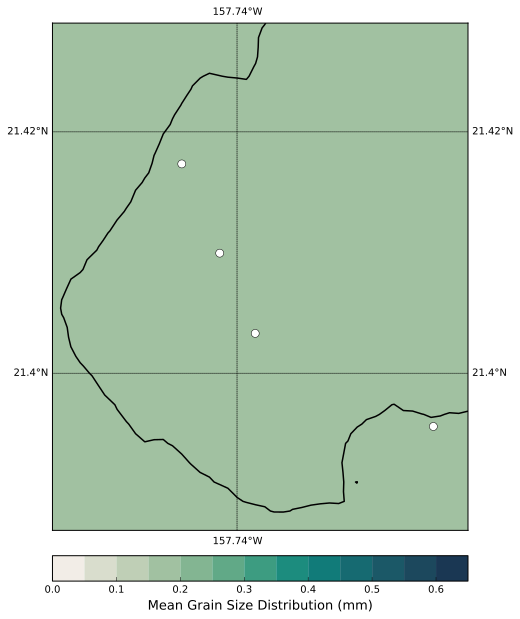

In [82]:
fig = plt.figure()
rcParams['figure.figsize'] = (14,10)

oahu_map.drawmapboundary()

# Parallels & meridians 
parallels = np.arange(21, 22, 0.02)
meridians = np.arange(-160, -157, 0.02)
oahu_map.drawparallels(parallels,labels=[True,True,True,True])
oahu_map.drawmeridians(meridians,labels=[True,True,True,True])

# Visualise grain size
cs = oahu_map.contourf(xHawaii,yHawaii, kailuaGZ, levels=np.arange(0.0,0.7,0.05), 
                       cmap=cmo.cm.tempo,  vmin=0.0, vmax=0.7 )

# Add shoreline contour
contour = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(0, 100, 100), 
                           colors = 'k', linestyles = 'solid',linewidths=1.5)

# Add grain-size location to the map
xgz,ygz = oahu_map(kLon, kLat)
oahu_map.plot(xgz, ygz, 'wo', markersize=8)

cbar = oahu_map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Mean Grain Size Distribution (mm)',size=13)

plt.show()
fig.savefig('figs/zone1GZ.pdf')

## Compute shear stress

Under pure waves (_i.e._, with no superimposed current), the wave-induced bed shear stress $\tau_w$ is typically conceived of as a quadratic bottom friction:

$$\tau_w = \frac{1}{2}\rho f_w U^2_{w,b}$$

where $\rho$ is water density, $f_w$ is the **wave friction factor**, and $U_{w,b}$ is the maximum over-the-wave-cycle horizontal wave-orbital speed at the bed. When the wave **boundary layer** is hydraulically rough turbulent, the wave friction factor, by definition [see Nielsen, 1992], depends solely on the **bed roughness** $k_b$ relative to the **wave-orbital semiexcursion** at the bed A_b.

Here we use:
$$ f_w = 1.39(A_b/k_b)^{-0.52} $$

where $A_b = U_{w,b}T$ [Soulsby, 1997] and $T$ is the wave period.

Following the scaling arguments of, for example, Smith and McLean [1977], $k_b$ may be evaluated as a **grain roughness** in which case the wave friction factor becomes a skin-friction wave friction factor and $\tau_w$ becomes a **skin friction**, which is the component of the bed shear stress that is thought to act on the bed-sediment grains, causing resuspension when the critical bed shear stress for initiation of sediment motion is exceeded. In the case of equation proposed above, the grain roughness is given as $2\pi D_{50}/12$, where $D_{50}$ is the median grainsize of the bed sediment.

In [83]:
# Parameters
rhow = 1024.

# Wave-orbital semiexcursion
Ab = kailuaUw * kailuaT

# Bed roughness
kb = np.pi * kailuaGZ*0.001 / 12.

# Wave friction factor
ids = np.where(np.logical_and(kb>0,Ab>0))
fw = np.zeros(kb.shape)
fw[ids] = 1.39 * np.power(Ab[ids]/kb[ids],-0.52)

# Shear stress
shear = 0.5 * rhow * fw * kailuaUw*kailuaUw
shear[r,c] = 0.

### Visualise shear stress map

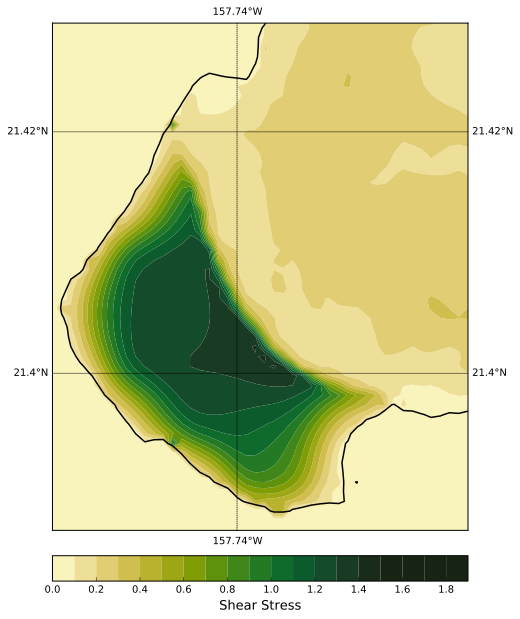

In [87]:
fig = plt.figure()
rcParams['figure.figsize'] = (14,10)

oahu_map.drawmapboundary()

# Parallels & meridians 
parallels = np.arange(21, 22, 0.02)
meridians = np.arange(-160, -157, 0.02)
oahu_map.drawparallels(parallels,labels=[True,True,True,True])
oahu_map.drawmeridians(meridians,labels=[True,True,True,True])

# Visualise shear stress
cs = oahu_map.contourf(xHawaii,yHawaii, shear, levels=np.arange(0.0,2.,0.1), 
                       cmap=cmo.cm.speed,  vmin=0.0, vmax=1.5 )

# Add shoreline contour
contour = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(0, 100, 100), 
                           colors = 'k', linestyles = 'solid',linewidths=1.5)

cbar = oahu_map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Shear Stress',size=13)

plt.show()
fig.savefig('figs/zone1Shear.pdf')

## Fall velocity

This is where we use the study results

### For calcareous sand from this study 

$$C_D = (\frac{a_3\nu}{d_n^{1.5}\sqrt{g} }+a_4 )^{a_5} +(\frac{a_6 \nu}{d_n^{1.5} \sqrt{g} }+a_7 )^{a_8} $$


$$ \omega^2 = \alpha \frac{4}{3}  \frac{(S-1)g}{C_D}  S_f ^{2/3} d_n $$

with 

- $\alpha =0.55$
- $a_3=9.5$
- $a_4=0.76$
- $a_5=2.92$
- $a_6=20.47$
- $a_7=1.02$
- $a_8=-48.15$

The following values have been chosen for the different parameters:

- water density $\rho_w = 1024 kg.m^{-3}$
- sediment density $\rho_s = 2600 kg.m^{-3}$
- dynamic viscosity $\mu = 1.002e^{-3}$ in Pa.s at 20 C
- kinematic viscosity $\nu = \mu / \rho_w$
- $S_f = 0.556$ 

In [88]:
# Setting up parameters
alpha = 0.55
a3 = 9.5
a4 = 0.76
a5 = 2.92
a6 = 20.47
a7 = 1.02
a8 = -48.15
rhos = 2600.
rhow = 1024.
mu = 1.002e-3
grav = 9.81

S = rhos / rhow
nu = mu / rhow
sqg = grav**(0.5)
Sf = 0.556

Define drag coefficient and settling velocity functions

In [89]:
def drag_coefficient_calcareous(sqg,nu,a3,a4,a5,a6,a7,a8,d):
    CD1 = np.power(a3*nu/(sqg*np.power(d,1.5))+a4,a5)
    CD2 = np.power(a6*nu/(sqg*np.power(d,1.5))+a7,a8)
    return CD1+CD2

def settling_velocity_calcareous(g,S,alpha,CD,Sf,d):
    return np.sqrt(alpha*4/3*(S-1.)*g/CD * np.power(Sf,2./3.) * d)

In [90]:
# Compute CD
CDcalc = drag_coefficient_calcareous(sqg,nu,a3,a4,a5,a6,a7,a8,kailuaGZ*0.001)  
CDcalc[r,c] = 0.
print 'Drag coefficient for carbonates: ',CDcalc.min(),CDcalc.max()

# Compute fall vekocity ws
wscalc = settling_velocity_calcareous(grav,S,alpha,CDcalc,Sf,kailuaGZ*0.001)
wscalc[r,c] = 0.
print 'Fall velocity for carbonates: ',wscalc.min(),wscalc.max()

Drag coefficient for carbonates:  0.0 5.64873971158
Fall velocity for carbonates:  0.0 0.0162808656194


### For siliciclastic sand

$$C_D = (\frac{a_1\nu}{d_n^{1.5}\sqrt{g} }+a_2 )^{a_3}  $$


$$ \omega^2 = \frac{4}{3}  \frac{(S-1)g}{C_D}  S_f ^{2/3} d_n $$

with 

- $a_1=96.45-74.74S_f^{-0.113}$
- $a_2=1.129-0.435S_f^{1.7}$
- $a_3=2.023$

values:

- water density $\rho_w = 1024 kg.m^{-3}$
- sediment density $\rho_s = 2600 kg.m^{-3}$
- dynamic viscosity $\mu = 1.002e^{-3}$ in Pa.s at 20 C
- kinematic viscosity $\nu = \mu / \rho_w$
- $S_f = 0.556$ 

In [91]:
# Define parameters
Sf = 0.556
a1 = 96.45 - 74.74*Sf**(-0.113)
a2 = 1.129 - 0.435*Sf**(1.7)
a3 = 2.023
rhos = 2600.
rhow = 1024.
mu = 1.002e-3
S = rhos / rhow
nu = mu / rhow
g = 9.81
sqg = g**(0.5)

Define drag coefficient and settling velocity functions

In [92]:
def drag_coefficient_siliciclastic(sqg,nu,a1,a2,a3,d): 
    return np.power(a1*nu/(sqg*np.power(d,1.5))+a2,a3)

def settling_velocity_siliciclastic(g,S,CD,Sf,d):
    return np.sqrt(4/3*(S-1.)*g/CD * np.power(Sf,2./3.) * d)

In [93]:
# Compute CD
CDsil = drag_coefficient_siliciclastic(sqg,nu,a1,a2,a3,kailuaGZ*0.001)  
CDsil[r,c] = 0.
print 'Drag coefficient for siliclastics: ',CDsil.min(),CDsil.max()

# Compute fall vekocity ws
wssil = settling_velocity_siliciclastic(g,S,CDsil,Sf,kailuaGZ*0.001)
wssil[r,c] = 0.
print 'Fall velocity for siliclastics: ',wssil.min(),wssil.max()

Drag coefficient for siliclastics:  0.0 8.03064330401
Fall velocity for siliclastics:  0.0 0.0159451053187


# Rouse number

The Rouse number ($P$) is a non-dimensional number in fluid dynamics which is used to define a concentration profile of suspended sediment and which also determines how sediment will be transported in a flowing fluid. 

It is a ratio between the sediment fall velocity $w_s$ and the upwards velocity on the grain as a product of the von Karman constant $\kappa$  and the shear velocity $u_b$.
    
$$P = \omega /(\kappa u_b)$$

In [94]:
vk = 0.4

# For carbonate sands
rousecalc = wscalc/(vk*shear)
r,c = np.where(shear<0.0001)
rousecalc[r,c] = 0.
kailuaRouseCalc = ndimage.gaussian_filter(rousecalc, sigma=2, order=0)
kailuaRouseCalc[r,c] = 0.
print 'Rouse number for carbonate sands: ',kailuaRouseCalc.min(),kailuaRouseCalc.max()

# For siliciclastic sands
rousesil = wssil/(vk*shear)
r,c = np.where(shear<0.0001)
rousesil[r,c] = 0.
kailuaRouseSil = ndimage.gaussian_filter(rousesil, sigma=2, order=0)
kailuaRouseSil[r,c] = 0.
print 'Rouse number for siliciclastic sands: ',kailuaRouseSil.min(),kailuaRouseSil.max()

# Ratio between the two Rouse number
diff = kailuaRouseCalc/kailuaRouseSil
diff[r,c] = 0.
print 'Rouse number ratio between carb. and sil. sands: ',diff.min(),diff.max()

Rouse number for carbonate sands:  0.0 0.415582065148
Rouse number for siliciclastic sands:  0.0 0.407011515988
Rouse number ratio between carb. and sil. sands:  0.0 1.02105726453


### Visualise results

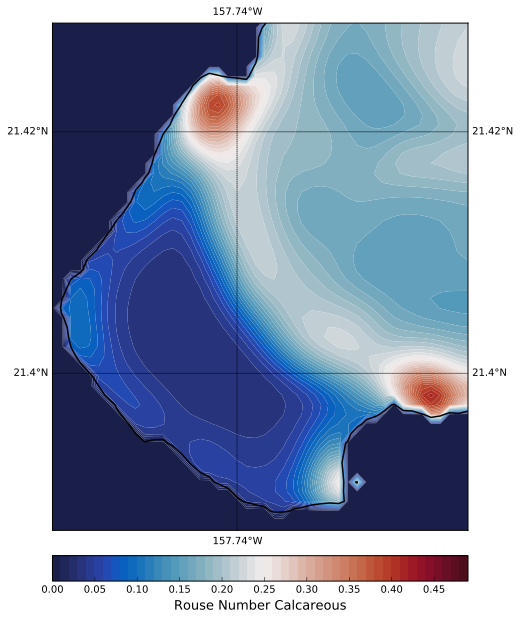

In [96]:
fig = plt.figure()
rcParams['figure.figsize'] = (14,10)

oahu_map.drawmapboundary()

# Parallels & meridians 
parallels = np.arange(21, 22, 0.02)
meridians = np.arange(-160, -157, 0.02)
oahu_map.drawparallels(parallels,labels=[True,True,True,True])
oahu_map.drawmeridians(meridians,labels=[True,True,True,True])

# Visualise Rouse Number
cs = oahu_map.contourf(xHawaii,yHawaii, kailuaRouseCalc, levels=np.arange(0.0,0.5,0.01), 
                       cmap=cmo.cm.balance,  vmin=0.0, vmax=0.5 )

# Add shoreline contour
contour = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(0, 100, 100), 
                           colors = 'k', linestyles = 'solid',linewidths=1.5)

cbar = oahu_map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Rouse Number Calcareous',size=13)

plt.show()
fig.savefig('figs/zone1RouseCal.pdf')

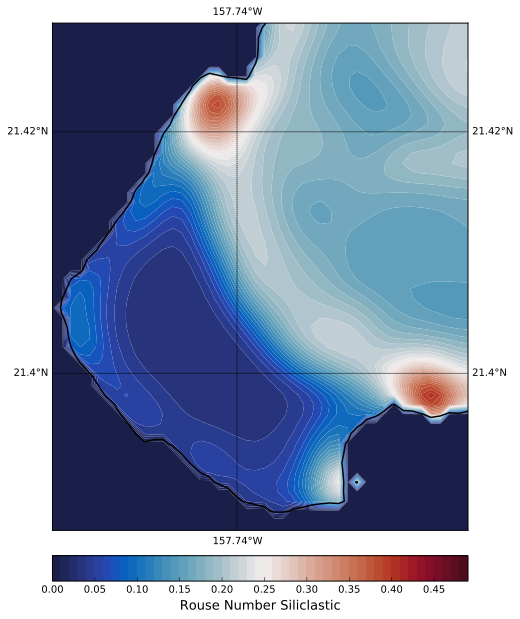

In [97]:
fig = plt.figure()
rcParams['figure.figsize'] = (14,10)

oahu_map.drawmapboundary()

# Parallels & meridians 
parallels = np.arange(21, 22, 0.02)
meridians = np.arange(-160, -157, 0.02)
oahu_map.drawparallels(parallels,labels=[True,True,True,True])
oahu_map.drawmeridians(meridians,labels=[True,True,True,True])

# Visualise Rouse Number
cs = oahu_map.contourf(xHawaii,yHawaii, kailuaRouseSil, levels=np.arange(0.0,0.5,0.01), 
                       cmap=cmo.cm.balance,  vmin=0.0, vmax=0.5 )

# Add shoreline contour
contour = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(0, 100, 100), 
                           colors = 'k', linestyles = 'solid',linewidths=1.5)

cbar = oahu_map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Rouse Number Siliclastic',size=13)

plt.show()
fig.savefig('figs/zone1Sil.pdf')

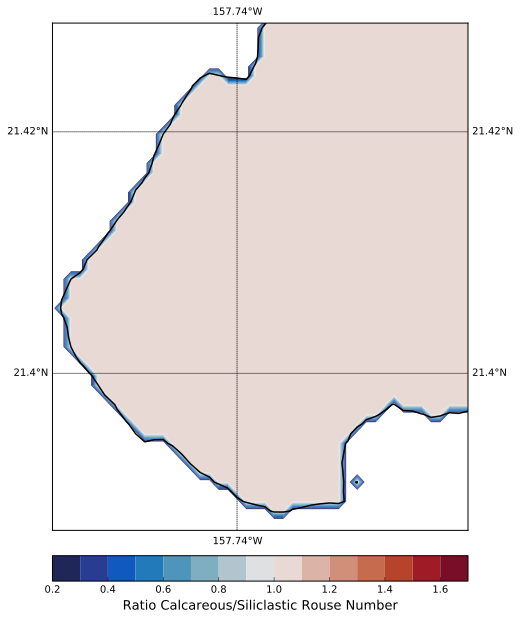

In [98]:
fig = plt.figure()
rcParams['figure.figsize'] = (14,10)

oahu_map.drawmapboundary()

# Parallels & meridians 
parallels = np.arange(21, 22, 0.02)
meridians = np.arange(-160, -157, 0.02)
oahu_map.drawparallels(parallels,labels=[True,True,True,True])
oahu_map.drawmeridians(meridians,labels=[True,True,True,True])

# Visualise Rouse Number
cs = oahu_map.contourf(xHawaii,yHawaii, diff, levels=np.arange(0.2,1.8,0.1), 
                       cmap=cmo.cm.balance,  vmin=0.2, vmax=1.8 )

# Add shoreline contour
contour = oahu_map.contour(xHawaii, yHawaii, kailuaZ, levels=np.arange(0, 100, 100), 
                           colors = 'k', linestyles = 'solid',linewidths=1.5)

cbar = oahu_map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Ratio Calcareous/Siliclastic Rouse Number',size=13)

plt.show()
fig.savefig('figs/zone1RouseDiff.pdf')